In [1]:
import pandas as pd
import psycopg2
import numpy as np
from geopy.distance import great_circle
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## 1. Extract GPS data from database

In [2]:
%%time
conn = psycopg2.connect(
    dbname = "gisdb", 
    user = "postgres",
    password =  "task4TH",
    host = "localhost"
)

# Query data from 2023-07-22 to the following week
query = """
WITH user_log_count AS (
    SELECT uuid, COUNT(*) AS log_count
    FROM blogwatcher.gps_logs
    WHERE logtime BETWEEN '2023-07-22' AND '2023-07-29'
    GROUP BY uuid
),
top_1_percent_users AS (
    -- Find users in the top 1% of log count
    SELECT uuid
    FROM user_log_count
    WHERE log_count >= (SELECT PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY log_count) FROM user_log_count)
)
SELECT 
    gps_logs.uuid,  
    gps_logs.logtime, 
    gps_logs.accuracy, 
    gps_logs.ios, 
    ST_AsText(gps_logs.geom) AS geom
FROM blogwatcher.gps_logs gps_logs
JOIN top_1_percent_users t1p ON gps_logs.uuid = t1p.uuid
WHERE gps_logs.logtime BETWEEN '2023-07-22' AND '2023-07-29'
ORDER BY gps_logs.uuid, gps_logs.logtime;
"""

# Extract data
gps_data = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# If the number of users exceeds 2000, randomly select 2000 users
top_users = gps_data['uuid'].unique()
if len(top_users) > 1000:
    selected_users = np.random.choice(top_users, 1000, replace=False)
    gps_data = gps_data[gps_data['uuid'].isin(selected_users)]

print(f"Selected {len(gps_data['uuid'].unique())} users for analysis.")

<timed exec>:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


Selected 1000 users for analysis.
CPU times: user 1min 10s, sys: 18 s, total: 1min 28s
Wall time: 7min 9s


In [3]:
gps_data

,uuid,logtime,accuracy,ios,geom
0,000049dc-07a6-d5a8-d430-979fa9358b12,2023-07-23 11:31:48,4.730,True,POINT(139.7433766 35.5455016)
1,000049dc-07a6-d5a8-d430-979fa9358b12,2023-07-23 11:31:57,14.240,True,POINT(139.7436457 35.5476073)
2,000049dc-07a6-d5a8-d430-979fa9358b12,2023-07-23 11:32:07,14.230,True,POINT(139.7444058 35.5495299)
3,000049dc-07a6-d5a8-d430-979fa9358b12,2023-07-23 11:32:17,14.230,True,POINT(139.7452543 35.5513915)
4,000049dc-07a6-d5a8-d430-979fa9358b12,2023-07-23 11:32:27,14.230,True,POINT(139.7461184 35.5536803)
...,...,...,...,...,...
73609810,ff23381f-9954-d6a0-276e-0b9ef8132e6d,2023-07-28 20:11:51,35.000,True,POINT(139.7988355 35.7161551)
73609811,ff23381f-9954-d6a0-276e-0b9ef8132e6d,2023-07-28 20:12:27,14.320,True,POINT(139.7992581 35.7161254)
73609812,ff23381f-9954-d6a0-276e-0b9ef8132e6d,2023-07-28 20:17:57,14.240,True,POINT(139.800548 35.7200652)
73609813,ff23381f-9954-d6a0-276e-0b9ef8132e6d,2023-07-28 20:18:07,14.179,True,POINT(139.8005809 35.7201169)


## 2. Analyze user activities by date
For each user on each day, calculate: a) Radius of gyration, b) Number of visited locations, c) Duration of stay at each location.
Calculate the radius of gyration and the number of visited locations:

In [4]:
def extract_lat_lon(group):
    group['latitude'] = group['geom'].apply(lambda x: float(x.split()[1][:-1]))   # Extract latitude
    group['longitude'] = group['geom'].apply(lambda x: float(x.split()[0].split('(')[1]))  # Extract longitude
    return group

def calculate_radius_of_gyration(group):
    coords = group[['latitude', 'longitude']].to_numpy()
    centroid = coords.mean(axis=0)  # Calculate the centroid
    radius_of_gyration = np.sqrt(np.mean([great_circle(coord, centroid).meters**2 for coord in coords]))
    return radius_of_gyration

def calculate_number_of_locations(group, epsilon=100, min_samples=3):
    coords = group[['latitude', 'longitude']].to_numpy()
    db = DBSCAN(eps=epsilon, min_samples=min_samples, metric=lambda x, y: great_circle(x, y).meters).fit(coords)
    return len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)  # Exclude noise points (-1)

# Calculate the stay time at each location
def calculate_stay_times(group, epsilon=100, min_samples=3, time_threshold=3600):
    coords = group[['latitude', 'longitude']].to_numpy()
    db = DBSCAN(eps=epsilon, min_samples=min_samples, metric=lambda x, y: great_circle(x, y).meters).fit(coords)
    group['cluster'] = db.labels_

    clustered_points = group[group['cluster'] != -1].copy()
    clustered_points['visit_id'] = 0
    clustered_points['prev_logtime'] = clustered_points['logtime'].shift(1)
    clustered_points['time_diff'] = (clustered_points['logtime'] - clustered_points['prev_logtime']).dt.total_seconds()

    visit_id = 0
    for idx, row in clustered_points.iterrows():
        if pd.isnull(row['time_diff']) or row['time_diff'] > time_threshold:
            visit_id += 1
        clustered_points.at[idx, 'visit_id'] = visit_id

    stay_summary = clustered_points.groupby('visit_id').agg({
        'logtime': ['min', 'max'],
        'latitude': 'mean',
        'longitude': 'mean'
    })

    stay_summary['duration'] = (stay_summary[('logtime', 'max')] - stay_summary[('logtime', 'min')]).dt.total_seconds()
    return stay_summary['duration'].values  # Return the duration of each stay

## 3. Analyze and visualize data by date
For each day and each user, calculate their radius of gyration, number of visited locations, and stay times. Then, visualize the daily distributions.

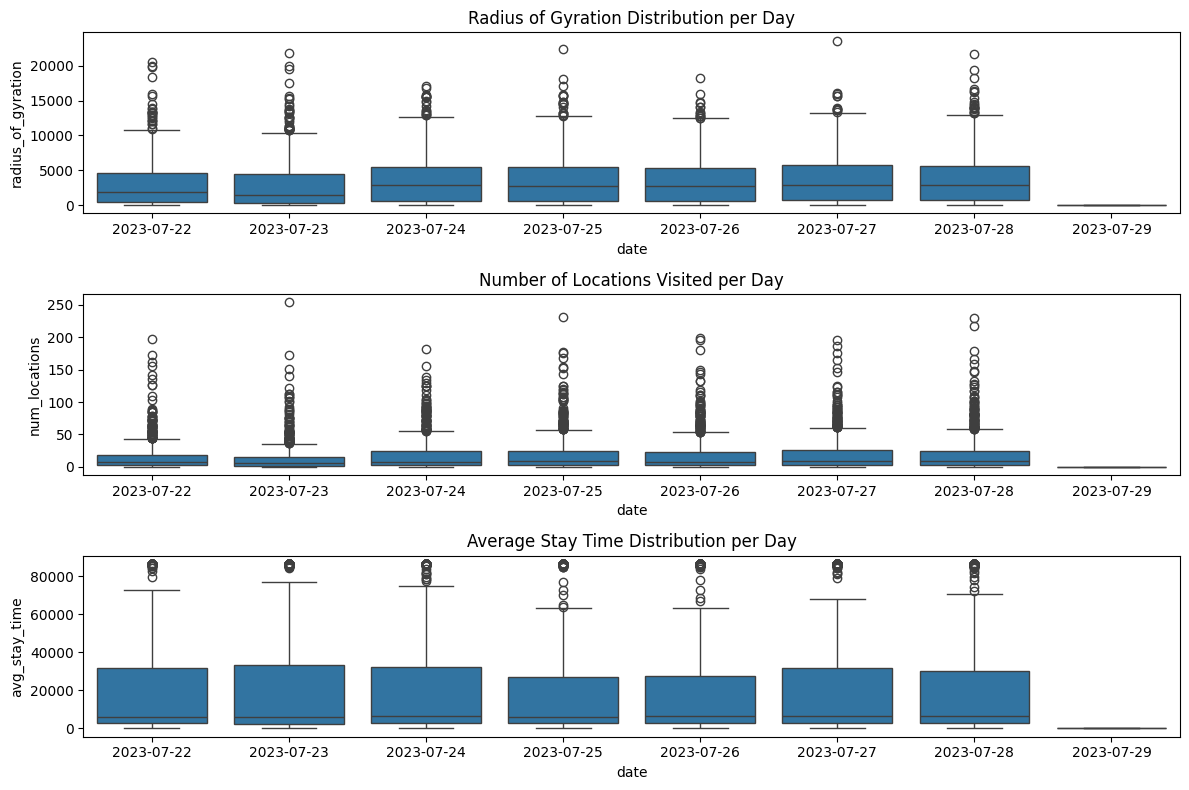

CPU times: user 2h 16min 27s, sys: 26.7 s, total: 2h 16min 54s
Wall time: 2h 22min 26s


In [5]:
%%time

results = {'date': [], 'uuid': [], 'radius_of_gyration': [], 'num_locations': [], 'avg_stay_time': []}

gps_data = extract_lat_lon(gps_data)

for date, date_group in gps_data.groupby(gps_data['logtime'].dt.date):
    for uuid, user_group in date_group.groupby('uuid'):
        radius_of_gyration = calculate_radius_of_gyration(user_group)
        num_locations = calculate_number_of_locations(user_group)
        stay_times = calculate_stay_times(user_group)

        results['date'].append(date)
        results['uuid'].append(uuid)
        results['radius_of_gyration'].append(radius_of_gyration)
        results['num_locations'].append(num_locations)
        results['avg_stay_time'].append(np.mean(stay_times) if len(stay_times) > 0 else 0)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Visualize daily distributions
plt.figure(figsize=(12, 8))

# Distribution of radius of gyration
plt.subplot(3, 1, 1)
sns.boxplot(x='date', y='radius_of_gyration', data=results_df)
plt.title('Radius of Gyration Distribution per Day')

# Distribution of number of visited locations
plt.subplot(3, 1, 2)
sns.boxplot(x='date', y='num_locations', data=results_df)
plt.title('Number of Locations Visited per Day')

# Distribution of average stay time
plt.subplot(3, 1, 3)
sns.boxplot(x='date', y='avg_stay_time', data=results_df)
plt.title('Average Stay Time Distribution per Day')

plt.tight_layout()
plt.show()

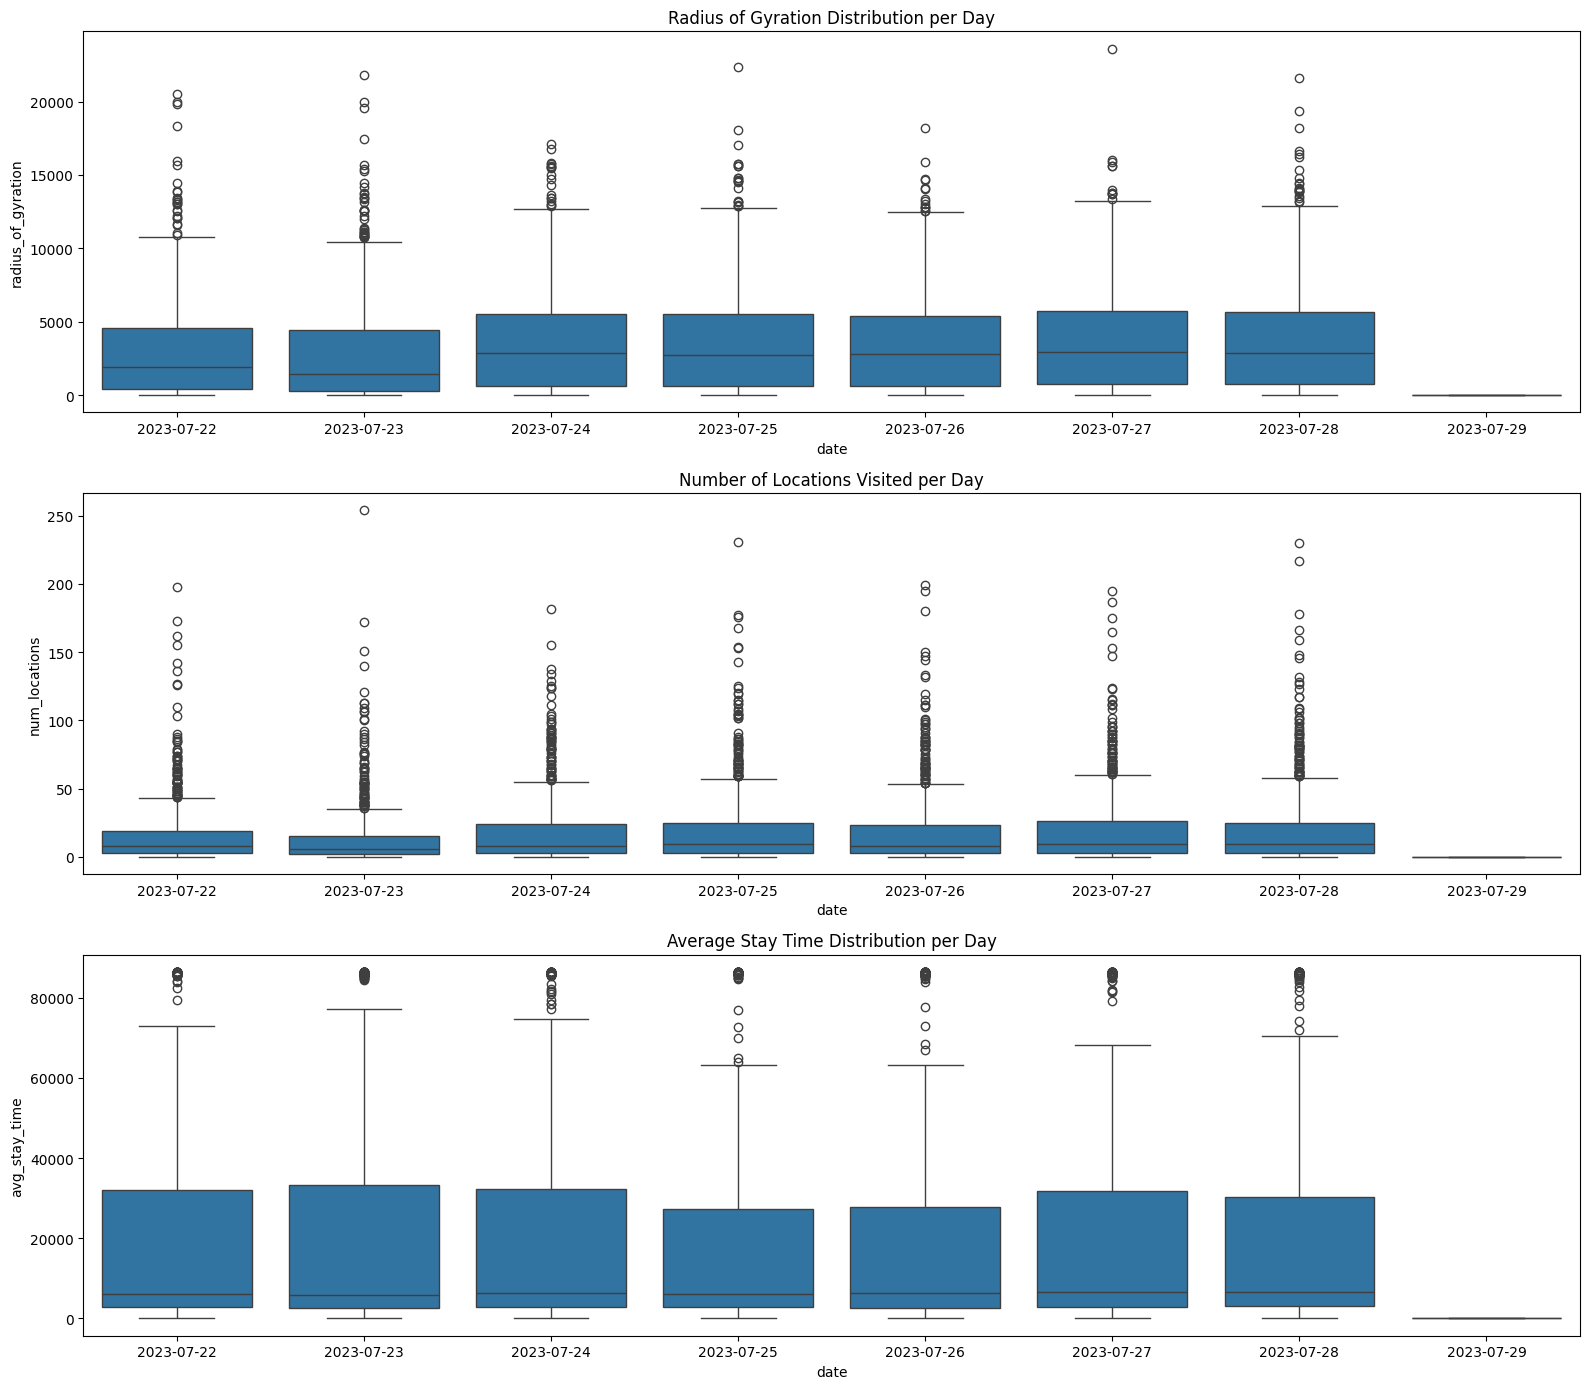

In [6]:
results_df = pd.DataFrame(results)

# Visualize daily distributions
plt.figure(figsize=(16, 14))

# Distribution of radius of gyration
plt.subplot(3, 1, 1)
sns.boxplot(x='date', y='radius_of_gyration', data=results_df)
plt.title('Radius of Gyration Distribution per Day')

# Distribution of number of visited locations
plt.subplot(3, 1, 2)
sns.boxplot(x='date', y='num_locations', data=results_df)
plt.title('Number of Locations Visited per Day')

# Distribution of average stay time
plt.subplot(3, 1, 3)
sns.boxplot(x='date', y='avg_stay_time', data=results_df)
plt.title('Average Stay Time Distribution per Day')

plt.tight_layout()
plt.show()

/home/owner/.conda/envs/postgre/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


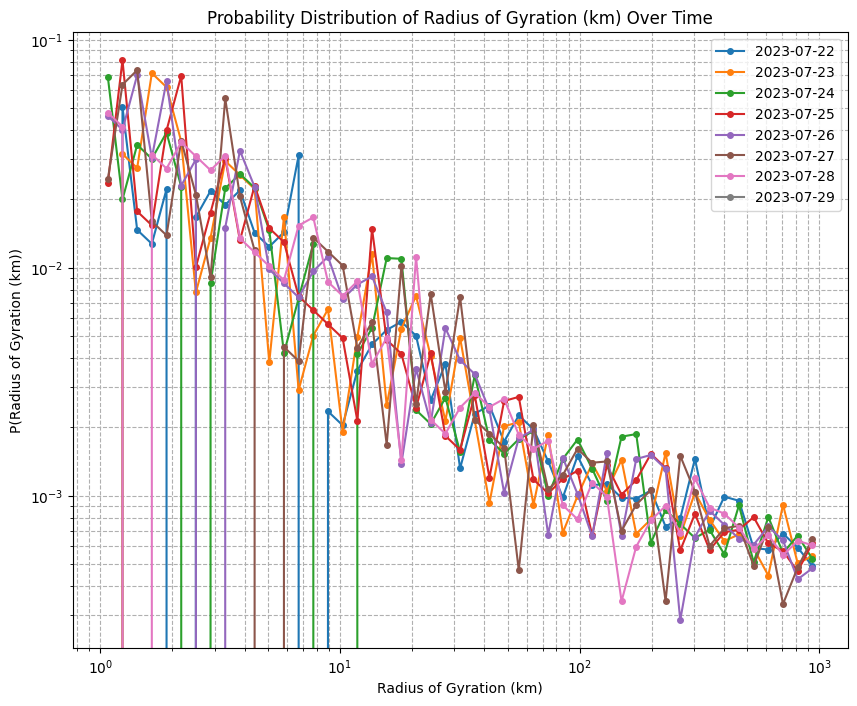

/home/owner/.conda/envs/postgre/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


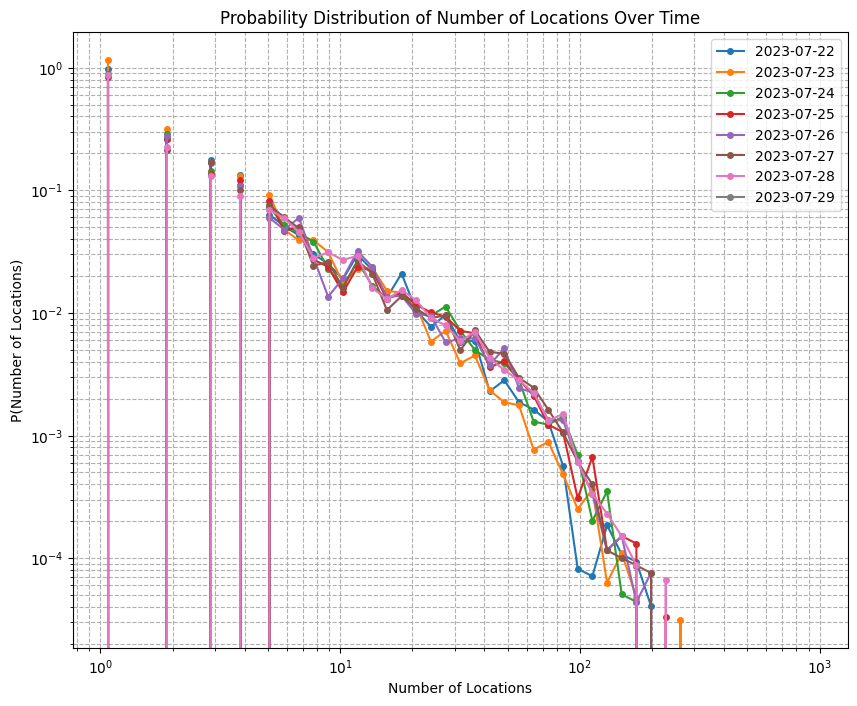

/home/owner/.conda/envs/postgre/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


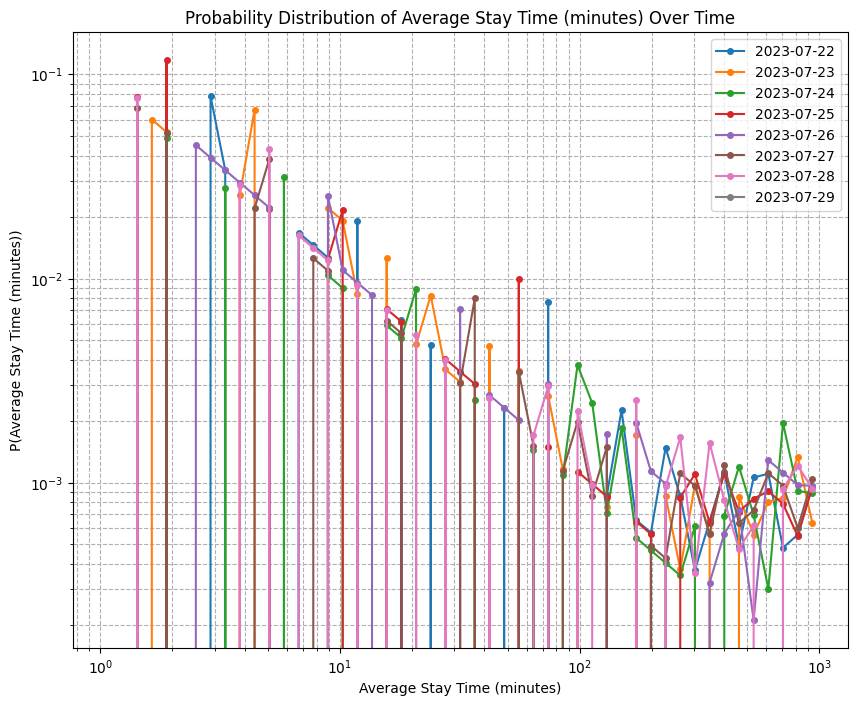

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# New visualization function for radius of gyration and other metrics
def visualize_metrics_over_dates(df, metric, metric_label):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    plt.figure(figsize=(10, 8))

    # Loop through each unique date in the data
    for start_time in df.index.unique():
        # Filter the data for the specific date
        metric_values = df[df.index == start_time][metric].dropna().values

        if len(metric_values) > 0:
            # Compute histogram for the metric values
            hist, bin_edges = np.histogram(
                metric_values, bins=np.logspace(np.log10(1), np.log10(1000), 50), density=True
            )
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

            # Plot the histogram on a log-log scale
            plt.plot(bin_centers, hist, '-o', label=f'{start_time.strftime("%Y-%m-%d")}', markersize=4)


    # Add labels, title, and grid to the plot
    plt.xscale('log')  # Log scale for x-axis
    plt.yscale('log')  # Log scale for y-axis
    plt.xlabel(f'{metric_label}')
    plt.ylabel(f'P({metric_label})')
    plt.title(f'Probability Distribution of {metric_label} Over Time')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()


# Visualize radius of gyration over actual dates
visualize_metrics_over_dates(
    results_df, 
    metric='radius_of_gyration', 
    metric_label='Radius of Gyration (km)'
)

# Visualize number of locations visited over actual dates
visualize_metrics_over_dates(
    results_df, 
    metric='num_locations', 
    metric_label='Number of Locations'
)

# Visualize average stay time over actual dates
visualize_metrics_over_dates(
    results_df, 
    metric='avg_stay_time', 
    metric_label='Average Stay Time (minutes)'
)

In [8]:
# Function to calculate the distances (jump lengths) between consecutive stay points
def calculate_jump_lengths(group, epsilon=100, min_samples=3, time_threshold=3600):
    coords = group[['latitude', 'longitude']].to_numpy()
    db = DBSCAN(eps=epsilon, min_samples=min_samples, metric=lambda x, y: great_circle(x, y).meters).fit(coords)
    group['cluster'] = db.labels_

    clustered_points = group[group['cluster'] != -1].copy()
    clustered_points['visit_id'] = 0
    clustered_points['prev_logtime'] = clustered_points['logtime'].shift(1)
    clustered_points['time_diff'] = (clustered_points['logtime'] - clustered_points['prev_logtime']).dt.total_seconds()

    visit_id = 0
    for idx, row in clustered_points.iterrows():
        if pd.isnull(row['time_diff']) or row['time_diff'] > time_threshold:
            visit_id += 1
        clustered_points.at[idx, 'visit_id'] = visit_id

    # Get jump lengths (distance between consecutive stay points)
    clustered_points = clustered_points.drop_duplicates('visit_id')
    clustered_points['next_latitude'] = clustered_points['latitude'].shift(-1)
    clustered_points['next_longitude'] = clustered_points['longitude'].shift(-1)
    
    # Calculate the jump lengths (distances between consecutive points)
    clustered_points['jump_length'] = clustered_points.apply(
        lambda row: great_circle(
            (row['latitude'], row['longitude']), (row['next_latitude'], row['next_longitude'])
        ).meters if not pd.isnull(row['next_latitude']) else None, axis=1
    )
    
    # Return jump lengths (filter out None values)
    return clustered_points['jump_length'].dropna().values


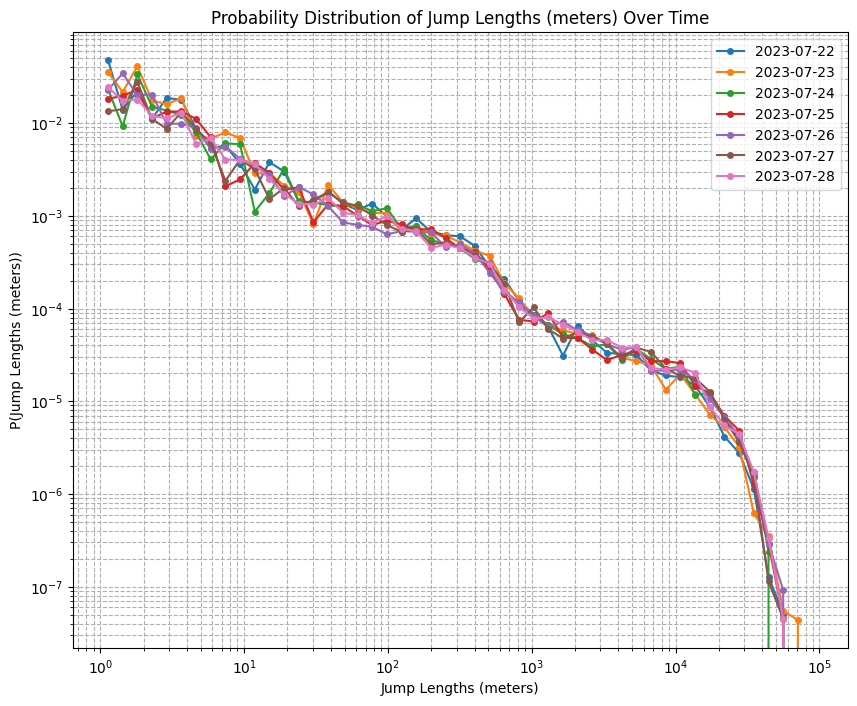

In [9]:
# New visualization function for jump lengths over time
def visualize_jump_lengths_over_dates(df, metric_label):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    plt.figure(figsize=(10, 8))

    # Loop through each unique date in the data
    for start_time in df.index.unique():
        # Filter the data for the specific date
        jump_lengths = df[df.index == start_time]['jump_lengths'].dropna().values

        if len(jump_lengths) > 0:
            # Compute histogram for the jump lengths
            hist, bin_edges = np.histogram(
                jump_lengths, bins=np.logspace(np.log10(1), np.log10(100000), 50), density=True
            )
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

            # Plot the histogram on a log-log scale
            plt.loglog(bin_centers, hist, 'o-', label=f'{start_time.strftime("%Y-%m-%d")}', markersize=4)

    # Add labels, title, and grid to the plot
    plt.xlabel(f'{metric_label}')
    plt.ylabel(f'P({metric_label})')
    plt.title(f'Probability Distribution of {metric_label} Over Time')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()


# For each user and each day, calculate jump lengths
jump_results = {'date': [], 'uuid': [], 'jump_lengths': []}

for date, date_group in gps_data.groupby(gps_data['logtime'].dt.date):
    for uuid, user_group in date_group.groupby('uuid'):
        jump_lengths = calculate_jump_lengths(user_group)
        if len(jump_lengths) > 0:
            jump_results['date'].extend([date] * len(jump_lengths))
            jump_results['uuid'].extend([uuid] * len(jump_lengths))
            jump_results['jump_lengths'].extend(jump_lengths)

# Convert to DataFrame
jump_results_df = pd.DataFrame(jump_results)

# Visualize the distribution of jump lengths
visualize_jump_lengths_over_dates(
    jump_results_df, 
    metric_label='Jump Lengths (meters)'
)